<a href="https://colab.research.google.com/github/beza0/deepLearning/blob/main/DL_ipynb_adl%C4%B1_not_defterinin_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kütüphaneler ve GPU kontrolü

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import shutil

from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

print("TensorFlow version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU devices: []


Kaggle’dan Çiçek Veri Setini İndirme

In [ ]:
from google.colab import files

uploaded = files.upload()


Saving archive.zip to archive.zip


ZIP dosyasını aç ve klasörleri düzenle

In [ ]:


import zipfile
import os
import shutil

# 1) ZIP dosyasının adını al (uploaded zaten tanımlı)
zip_name = next(iter(uploaded))
print("ZIP dosyası:", zip_name)

# 2) ZIP'i "flowers_raw" klasörüne aç
with zipfile.ZipFile(zip_name, 'r') as z:
    z.extractall("flowers_raw")

print("flowers_raw içeriği:", os.listdir("flowers_raw"))

# 3) Eğer ZIP içinde ekstra klasör varsa (ör: flowers, flower_photos, archive…), otomatik algıla
root_contents = os.listdir("flowers_raw")

if len(root_contents) == 1 and os.path.isdir(os.path.join("flowers_raw", root_contents[0])):
    inner = os.path.join("flowers_raw", root_contents[0])
else:
    inner = "flowers_raw"

print("Kullanılacak klasör:", inner)

# 4) flowers_data klasörünü oluştur
os.makedirs("flowers_data", exist_ok=True)

# 5) Sinif klasörlerini flowers_data içine taşı
for name in os.listdir(inner):
    src = os.path.join(inner, name)
    dst = os.path.join("flowers_data", name)
    if os.path.isdir(src):
        shutil.move(src, dst)

print("flowers_data içeriği:", os.listdir("flowers_data"))


ZIP dosyası: archive.zip
flowers_raw içeriği: ['flowers']
Kullanılacak klasör: flowers_raw/flowers
flowers_data içeriği: ['rose', 'sunflower', 'daisy', 'dandelion', 'tulip']


Train / Validation veri generator'larını oluşturma

In [ ]:


from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = "flowers_data"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    subset='training',
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    subset='validation',
    class_mode='categorical',
    shuffle=False
)

print("Sınıflar:", train_data.class_indices)
print("Sınıf sayısı:", train_data.num_classes)


Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.
Sınıflar: {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
Sınıf sayısı: 5


MobileNetV2 Modelinin Kurulumu

In [ ]:

import tensorflow as tf

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # Transfer learning — tabanı dondurduk

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(train_data.num_classes, activation='softmax')
])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Modeli Compile Et ve Eğitime Hazırla

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Modeli Eğit

In [ ]:

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.6141 - loss: 1.0291 - val_accuracy: 0.8349 - val_loss: 0.4625
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.8589 - loss: 0.4097 - val_accuracy: 0.8686 - val_loss: 0.3848
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.9037 - loss: 0.3094 - val_accuracy: 0.8616 - val_loss: 0.3863
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.8995 - loss: 0.2894 - val_accuracy: 0.8663 - val_loss: 0.3826
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.9166 - loss: 0.2427 - val_accuracy: 0.8826 - val_loss: 0.3584
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.9309 - loss: 0.2225 - val_accuracy: 0.8651 - val_loss: 0.3747
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.9451 - loss: 0.1880 - val_accuracy: 0.8802 - val_loss: 0.3501
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.9496 - loss: 0.1814 - val_accu

Accuracy / Loss Grafikleri

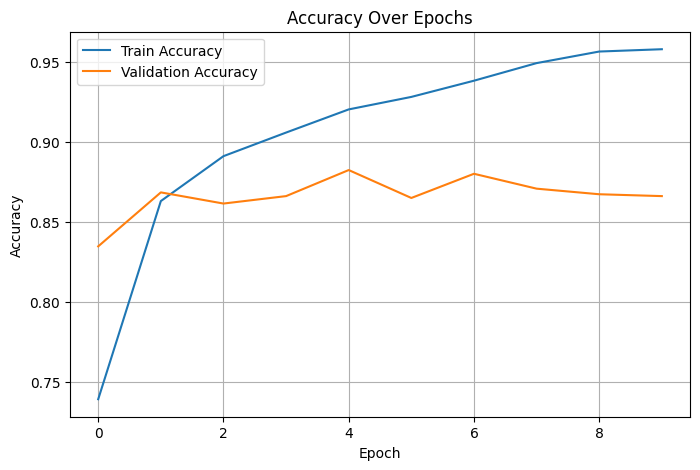

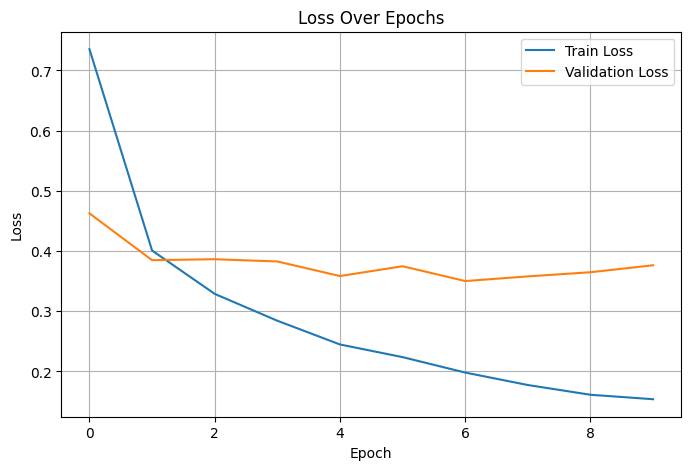

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Confusion Matrix + Classification Report

27/27 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

       daisy       0.83      0.91      0.87       152
   dandelion       0.92      0.90      0.91       210
        rose       0.82      0.87      0.85       156
   sunflower       0.83      0.88      0.85       146
       tulip       0.91      0.78      0.84       196

    accuracy                           0.87       860
   macro avg       0.86      0.87      0.86       860
weighted avg       0.87      0.87      0.87       860



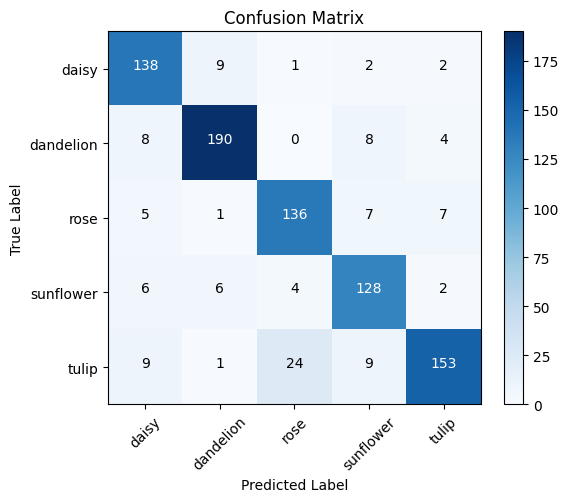

In [ ]:
val_data.reset()
y_true = val_data.classes
y_pred = np.argmax(model.predict(val_data), axis=1)
class_names = list(train_data.class_indices.keys())

print("\nCLASSIFICATION REPORT:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)

for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i, j],
                 ha="center",
                 color="white" if cm[i, j] > cm.max()/2 else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()
